This code is split into 3 parts

Part 1: Web crawling

Part 2: Web scraping

Part 3: Data Visualization


In [ ]:
import math
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import time

In [ ]:
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"} #our browser identity

In [ ]:
website = 'https://www.discogs.com/seller/parkavecds/profile' # <----direct seller page link (this the only part of the code that requires user input, any direct link to a seller's page will work)

In [ ]:
#You may want to use another seller's profile to test this code that has less inventory, and therefore takes less time to execute.
#The above seller takes about 8 hours to scrape, the following seller takes about 10 minutes to scrape:
# website = 'https://www.discogs.com/seller/TheRecordSpot_/profile'

In [ ]:
#Determines the number of pages of listings the seller has, and also determines the number of products the seller has

website = '/'.join(website.split('/')[:5])+ "/profile?sort=listed%2Cdesc&limit=250&page="
response = requests.get(website, headers = headers)
soup = BeautifulSoup(response.content, 'html.parser')

pagenum_container = soup.find('strong',{'class':'pagination_total'})

pattern = r'<strong class="pagination_total">\s*(\d[\d,]*)\s*–\s*\d+\s*of\s*([\d,]+)\s*</strong>'

match = re.search(pattern, str(pagenum_container))

if match:
    number = int(match.group(2).replace(',', ''))

    total_products=number

total_pages = math.ceil(total_products / 250)

In [ ]:
#builds the page urls
page_urls=[]
for page in range(1, total_pages + 1):
        url = website + str(page)
        page_urls.append(url)

In [ ]:
#Gets the product urls from each page of listings
complete_url =[]
broken_url=[]
for url in page_urls:
  response = requests.get(url, headers = headers)
  soup = BeautifulSoup(response.content, 'html.parser')
  results_container = soup.find_all('td',{'class': 'item_description'})
  pattern = r'/release/([^"]+)'

  for item in results_container:
    match = re.search(pattern, str(item))

    if match:
      extracted_link = match.group(0)
      broken_url.append(extracted_link)


  for url in broken_url:
    complete_url.append("https://www.discogs.com" + url)
  time.sleep(10)


In [ ]:
#PART 2 OF CODE (web scraping)

In [ ]:
#list type variables to store our data that we will collect from each product link
artist=[]
album=[]
country=[]
year=[]
genre=[]
rating=[]
have=[]
want=[]
low=[]
median=[]
high=[]

In [ ]:
#Scrapes each product link obtained in part 1 for 11 points of data each

for link in complete_url:
  time.sleep(10)
  response = requests.get(link, headers = headers)
  soup = BeautifulSoup(response.content, 'html.parser')
  results_container_for_item_name = soup.find_all('h1',{'class': 'title_1q3xW'})
  results_container_for_table = soup.find_all('div',{'class': 'info_23nnx'})
  results_container_for_section = soup.find_all('div',{'class':'items_3gMeU'})


  #gets artist name
  pattern1 = r'>([^<]+)</a></span>\s*[^>]*\s*<!--[^-]*-->\s*([^<]+)</h1>'
  pattern2 = r'>([^<]+)</a>.*?</span>\s*[^>]*\s*<!--[^-]*-->\s*([^<]+)</h1>'
  match = re.search(pattern1, str(results_container_for_item_name))


  if match:
    artist_name = match.group(1)
    artist.append(artist_name)
  else:
    match = re.search(pattern2, str(results_container_for_item_name))
    if match:
      artist_name = match.group(1)
      artist.append(artist_name)
    else:
      artist.append("Artist name not found in the html code")


  #gets the album name
  pattern1 = r'</a></span>\s*[^>]*\s*<!--[^-]*-->\s*([^<]+)</h1>'
  pattern2 = r'</a>.*?</span>\s*[^>]*\s*<!--[^-]*-->\s*([^<]+)</h1>'
  match = re.search(pattern1, str(results_container_for_item_name))

  if match:
    album_name = match.group(1)
    album.append(album_name)
  else:
    match = re.search(pattern2, str(results_container_for_item_name))
    if match:
      album_name = match.group(1)
      album.append(album_name)
    else:
      album.append("Album name not found in the HTML code.")

  #gets the country released
  pattern = r'>([^<]+)</a></td></tr><tr><th scope="row">Released'
  match = re.search(pattern, str(results_container_for_table))

  if match:
    country_released = match.group(1)
    country.append(country_released)
  else:
    country.append("Country released not found in the HTML code.")

  #gets the year
  pattern = r'>(?:[^>]*\s)?(\d{4})</time></a></td></tr><tr><th scope="row">Genre<'
  match = re.search(pattern, str(results_container_for_table))

  if match:
    year_released = match.group(1)
    year.append(year_released)
  else:
    year.append("--")

  #gets the genre
  pattern = r'>Genre<!-- -->:</th><td><[^>]*hreflang="en">([^<]+)</a>'
  match = re.search(pattern, str(results_container_for_table))

  if match:
    genre_match = match.group(1)
    genre.append(genre_match)
  else:
    print("Genre not found in the HTML code.")

  #gets the average rating
  pattern1 = r'>Avg Rating<!-- -->:</span><span>(\d+(\.\d{1,2})?)<!--'
  pattern2 = r'>Avg Rating<!-- -->:</span><span>(\d+(?:\.\d{1,2})?|--)<!--'
  match = re.search(pattern1, str(results_container_for_section))

  if match:
    avg_rating = match.group(1)
    rating.append(avg_rating)
  else:
    match = re.search(pattern2, str(results_container_for_section))
    if match:
      avg_rating = match.group(1)
      rating.append(avg_rating)
    else:
      rating.append("Average rating not found in the HTML code.")

  #gets the # of people that have the album
  pattern = r'>Have<!-- -->:</span><a[^>]*hreflang="en">(\d+)</a></li><li><span class="name_34rAK">Want<!-- -->'
  match = re.search(pattern, str(results_container_for_section))

  if match:
    have_count = match.group(1)
    have.append(have_count)
  else:
    have.append("--")

  #gets the # of people that want the album
  pattern = r'>Want<!-- -->:</span><a[^>]*hreflang="en">(\d+)</a></li><li><span class="name_34rAK">Avg Rating<!-- -->:'
  match = re.search(pattern, str(results_container_for_section))

  if match:
    want_count = match.group(1)
    want.append(want_count)
  else:
    want.append("--")

  #gets the low price
  pattern1 = r'>Low<!-- -->:</span><span>\$(\d+\.\d{1,2})</span>'
  pattern2 = r'Low<!-- -->:</span><span>(\d+\.\d{2}|--)</span>'
  match = re.search(pattern1, str(results_container_for_section))

  if match:
    low_price = match.group(1)
    low.append(low_price)
  else:
    match = re.search(pattern2, str(results_container_for_section))
    if match:
      low_price = match.group(1)
      low.append(low_price)
    else:
      low.append("--")

  #gets the median price
  pattern1 = r'>Median<!-- -->:</span><span>\$(\d+\.\d{1,2})</span>'
  pattern2 = r'Median<!-- -->:</span><span>(\d+\.\d{2}|--)</span>'
  match = re.search(pattern1, str(results_container_for_section))

  if match:
    median_price = match.group(1)
    median.append(median_price)
  else:
    match = re.search(pattern2, str(results_container_for_section))
    if match:
      median_price = match.group(1)
      median.append(median_price)
    else:
      median.append("--")

  #gets the high price
  pattern1 = r'>High<!-- -->:</span><span>\$(\d+\.\d{1,2})</span>'
  pattern2 = r'High<!-- -->:</span><span>(\d+\.\d{2}|--)</span>'
  match = re.search(pattern1, str(results_container_for_section))

  if match:
    high_price = match.group(1)
    high.append(high_price)
  else:
    match = re.search(pattern2, str(results_container_for_section))
    if match:
      high_price = match.group(1)
      high.append(high_price)
    else:
      high.append("--")

#cleans up data so it is read easier by Pandas
artist = [re.sub(r'\s*\([^)]*\)', '', a).strip() for a in artist]
have = ["0" if h == "--" else h for h in have]
want = ["0" if w == "--" else w for w in want]
rating = ["0" if r == "--" else r for r in rating]
low = ["0" if l == "--" else l for l in low]
median = ["0" if m == "--" else m for m in median]
high = ["0" if h == "--" else h for h in high]
artist = [a.replace("&amp;", "&") for a in artist]
album = [a.replace("&amp;", "&") for a in album]
genre = [g.replace("&amp;", "&") for g in genre]
country = [c.replace("&amp;", "&") for c in country]

In [ ]:
output= {'Artist':artist,'Album':album,'Country':country,'Year':year,'Genre':genre,'Have':have,'Want':want,'Rating':rating,'Low':low,'Median':median,'High':high} #separates columns for Pandas

In [ ]:
#PART 3 OF CODE (data visualization) IN PROGRESS

In [ ]:
df = pd.DataFrame(output) #creates a pandas data frame given the data we collected

In [ ]:
#makes sure each column is of the correct data type, this way there won't be any errors when creating a graph
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
df['Have'] = df['Have'].astype(int)
df['Want'] = df['Want'].astype(int)
df['Rating'] = df['Rating'].astype(float)
df['Low'] = df['Low'].astype(float)
df['Median'] = df['Median'].astype(float)
df['High'] = df['High'].astype(float)

In [ ]:
#imports for chart making
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#Creates a graph showing the store's inventory value based off the low, median, and high price of every single product they have listed.

sum_low = df['Low'].sum()
sum_median = df['Median'].sum()
sum_high = df['High'].sum()


fig = px.bar(x=['Low', 'Median', 'High'], y=[sum_low, sum_median, sum_high],
             color=['Low', 'Median', 'High'], color_discrete_map={'Low': 'red', 'Median': 'orange', 'High': 'green'},
             labels={'x': 'Price Level', 'y': 'Value($)'}, title='Store Inventory Value')

for trace in fig.data:
    yval = trace.y[0]
    label = '${:,.2f}'.format(yval)
    fig.add_annotation(x=trace.x[0], y=yval + 0.05, text=label, showarrow=False, font=dict(color='black', size=19), yshift=10)

# Show the plot
fig.show()

In [ ]:
#Creates pie chart showing amount of products per genre they carry

genre_counts = df['Genre'].value_counts().reset_index()

# Create a pie chart using plotly
fig = px.pie(genre_counts, names='index', values='Genre',
             labels={'index': 'Genre', 'Genre': '# of Albums'},
             title='Number of Albums by Genre')

# Show the plot
fig.show()

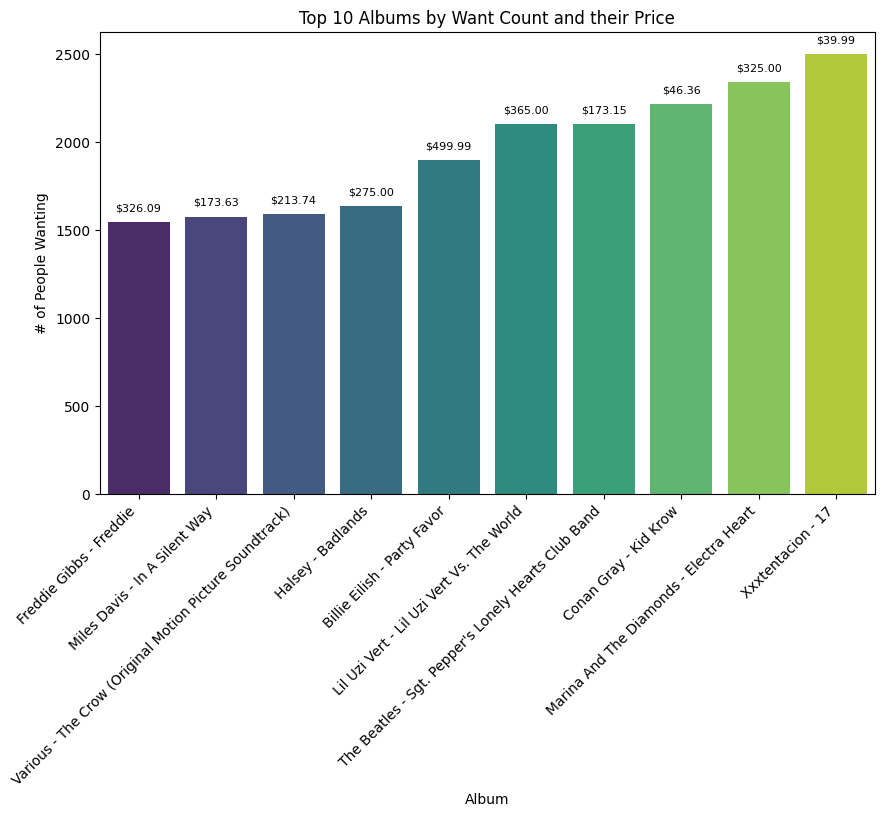

In [ ]:
#Creates a graph of the top 10 albums based off the amount of people that want them, also the price is visible for each of these albums to be able to see the relationship between demand and price

df['Combined'] = df['Artist'] + ' - ' + df['Album']


top_10_albums = df.nlargest(10, 'Want')[::-1]


palette = sns.color_palette("viridis", len(top_10_albums))


plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_albums['Combined'], y=top_10_albums['Want'], palette=palette)


for p, label in zip(ax.patches, top_10_albums['High']):
    ax.annotate(f"${label:.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.xlabel('Album')
plt.ylabel('# of People Wanting')
plt.title('Top 10 Albums by Want Count and their Price')


plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
#Creates a graph with the top 10 most expensive albums, and also visually shows the # of people that want that product compared to the # people that have that album
df_top10 = df.sort_values(by='High', ascending=False).head(10)

fig = px.bar(df_top10, x=df_top10['Artist'] + ' - ' + df_top10['Album'],
             y=['High', 'Want', 'Have'],
             labels={'x': 'Artist - Album', 'value': 'Amount'},
             title='Top 10 Most Expensive Albums with Want and Have Values',
             )

fig.update_layout(legend_title_text='Legend')
fig.for_each_trace(lambda t: t.update(name=t.name.replace("High", "Price ($)")))

fig.show()

In [ ]:
#Creates a graph showing the amount of products they carry based on the release year, the red line indicates the average price for records for that year.

df_filtered = df[(df['Year'] >= 1980) & (df['Year'] <= 2023)]

year_counts = df_filtered['Year'].value_counts().sort_index()

two_year_counts = year_counts.groupby((year_counts.index // 2) * 2).sum().reset_index()

average_price = df_filtered.groupby((df_filtered['Year'] // 2) * 2)['Median'].mean().reset_index()

fig = go.Figure()

fig.add_trace(go.Scatter(x=two_year_counts['index'], y=two_year_counts['Year'],
                         fill='tozeroy', mode='lines', line=dict(color='blue'),
                         name='Number of Albums'))

fig.update_layout(yaxis2=dict(title='Average Price ($)', overlaying='y', side='right', range=[0, 50]))

fig.add_trace(go.Scatter(x=average_price['Year'], y=average_price['Median'],
                         mode='lines', line=dict(color='red', dash='dash'),
                         name='Average Price', yaxis='y2'))

fig.update_layout(title='# of Albums and Average Price by Year',
                  xaxis=dict(title='Year'),
                  yaxis=dict(title='Number of Albums'))

fig.show()